In [172]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from tqdm import tqdm
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from sklearn.decomposition import PCA

from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents, random_label_cmap, star_dist3D
from stardist import fill_label_holes
from stardist.matching import matching_dataset
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()

# Model structure

## Problem
We are given a training dataset of unannotated **aligned** worm images (as TIFF files e.g.) and want to segment and annotate all of them in one go in an unsupervised fashion.

## Data
We use 30 TIFF images of partly annotated worm images, i.e. each ground truth image of a worm comes with a ground truth (GT) label: its ground truth segmentation with semantic annotation. During training we will only use the images (unsupervised learning). We use the GT annotations only for evaluating our method.

## Method
1) **Instance Segmentation:** Create an instance segmentation of each given image.
2) **Nuclei grouping:** Create groups of nuclei across worms where a group consists of nuclei (one per worm) that are "most similar", i.e. have similar relative position and shape. Those groups ideally represent nuclei that have the same ground truth annotation (which is not yet known as tha data is unlabeled).
3) **Induced annotation:** Choose a GT annotation of one (or multiple) worms in the training dataset. This annotation induces annotations across all other worms. Namely, by assigning the label X to each nucleus in the group that contains the nucleus with GT annotation X.
4) **Atlas creation:** All 30 worms together with their induces annotations can be used to form an atlas (i.e. statistical example worm).
5) **Evaluation:** We can compare the incuded annotation with the GT annotation of all other 29 worms. This way we can compute evaluation metrics and compare them with baseline models.
6) **Prediction:** Given a atlas created from a training dataset and an unseen worm image and we perform semantic segmentation of the new worm as follows: First create an instance segmentation as in (1), note that this step is modular and the method of nuclei instance segmentation can be varied. Then compute the nuclei group to which each segmented nucleus in the unseen worm most likely belongs to w.r.t. to the atlas. This induces an annotation of the segmented nuclei instances.

# 1. Instance Segmentation

**Goal:** Given an input worm image this step produces an instance segmentation of the present nuclei.

This can be done using predictions of a pretrained instance segmentation model, e.g. StarDist. In case we do not use already available pretrained segmentation models we need to train an instance segmentation model from scratch. In that case we need additional "pretraining data", i.e. worm images (not present in the training dataset) and their corresponding instance segmentation masks.

<div class="alert alert-block alert-warning">
TODO:
Find a good instance segmentation model that performs well on the worm dataset and use the resulting segmentations. In case that model is StarDist we can use its feature reprentations in the next step.
</div>

In [98]:
DATA_PATH = os.path.join("worm_data", "val") # Should point to a path that contains "images" and "masks" folders with tiff files.
USE_MODEL = False # Use pretrained model to create a segmentation of input images, otherwise use segmentation masks
MODEL_NAME = "stardist"

In [17]:
if USE_MODEL:
    # Load images
    X = sorted(glob(os.path.join(DATA_PATH,'images','*.tif')))
    X = list(map(imread,X))
    axis_norm = (0,1,2)   # normalize channels independently

    # Load model
    model = StarDist3D(None, name=MODEL_NAME, basedir='models')

    #Predict images
    instance_masks = []
    instance_details = []
    for i in range(len(X)):
        img = normalize(X[i], 1,99.8, axis=axis_norm)
        labels, details = model.predict_instances(img)
        instance_masks.append(labels)
        instance_details.append(details)

else: # Use segmentation masks
    # Load images
    Y = sorted(glob(os.path.join(DATA_PATH,'masks','*.tif')))
    Y = list(map(imread,Y))
    instance_masks = [np.array(y, dtype=int) for y in Y]
    instance_details = None

# 2. Feature extraction

**Given:** We have $N$ worm images $X_1,\dots,X_N$ and their corresponding instance segmentation masks $Y_1,\dots,Y_N$. Each mask $Y_i$ contains $n_i$ nuclei instances $P^i_1,\dots,P^i_{n_i}$ (ideally all $n_i$ are equal to 558, the number of cells in each c_elegans organism). We shortly write $P_{ij}$ for the set of all pixels forming nucleus instance $j=1,\dots,n_i$ in worm image $X_i$, and identify this set with the visible instance $P^i_j$.

**Goal:** To each pixel in an instance $P_{ij}$ we assign a vector "describing the position & geometry" of the instance that pixel is part of. The following features are extracted for each pixel of an instance:
1) the normalized distance to background of the pixel (= probability of center of the pixel)
2) the distances w.r.t. to a fixed set of directions
3) the position of the pixel
4) the vector from the worm centroid to the instance centroid

<div class="alert alert-block alert-warning">
TODO:
I am not sure if it is better to have different vectors for different pixels of an instance, or if it might be better to just have one set of features for the whole instance. In the first option the problem is that far away pixels of the same instance will have non-similar features which we do not want. In the second option the problem is that we might have too little information extracted from the whole instance.
</div>

**Method:** We have two possible options to extract those features:
1) *By computation:* Given an instance segmentation from any model we compute these features using explicit mathematical expressions.
2) *By prediction:* Given a raw worm image we can use the StarDist model directly to obtain an instance segmentation of the image, together with predictions of the above listed features.

Method (2) can be used if there is no good instance segmentation available and the StarDist model performs well on the given dataset, which needs to be tested first. If a GT instance segmentation is available or there are models that produce better segmentation results than StarDist then Method (1) should be used.


In [125]:
NUM_RAYS = 6 # Number of 3D rays to represent the shape of a nucleus instance; default: 64
USE_ANISOTROPY = True

In [166]:
# TODO: We want a list "all_instances" of dictionaries which is indexed by tuples (worm_id, instance_id).
# For each instances (w_id, i_id), we want a dictionary which can be easily extended with the following keys:
# - worm_centroid (3 dim vector)
# - centroid_abs (3 dim vector), centroid w.r.t. to image origin
# - centroid_rel (3 dim vector), centroid w.r.t. to worm centroid
# - shape_dist (64 dim vector), distance w.r.t. to 64 base rays

'''This class mainly holds information about all instances of a given list of instance segmentation masks of worms.'''
class InstanceCollection:
    def __init__(self, instance_masks, instance_details):
        self.instance_masks = instance_masks
        self.instance_details = instance_details

        self.num_worms = len(instance_masks)
        # TODO: Multiprocessing
        # self.worms = self.create_worms(num_jobs)
        # def create_worms(self, num_jobs):
        #     return Parallel(n_jobs=num_jobs)(
        #         delayed(WormSegmentation)(worm_id, self.instance_masks[worm_id]) for worm_id in range(self.num_worms)
        #     )
        self.worms = [WormSegmentation(worm_id, instance_masks[worm_id]) for worm_id in range(self.num_worms)]

        self.all_instances ={}
        for worm_idx in range(self.num_worms):
            self.all_instances.update(self.worms[worm_idx].instances)        

'''This class mainly holds information about all instances of a given worm instance segmentation.'''
class WormSegmentation:
    def __init__(self, id, mask):
        self.worm_id = id
        self.mask = mask
        self.worm_centroid = self.get_worm_centroid()

        self.instance_ids = self.get_instance_ids()
        self.instance_count = len(self.instance_ids)
        self.instances = {(self.worm_id, instance_id): Instance(instance_id, self.worm_id, self.worm_centroid, self.mask) for instance_id in self.instance_ids}


    def get_instance_ids(self):
        unique_values = np.unique(self.mask)
        return unique_values[unique_values != 0] # Remove background

    def get_worm_centroid(self):
        fg_pixels = np.where(self.mask > 0)
        return np.mean(fg_pixels, axis=1)

'''This class mainly holds information about a single instance, e.g. its centroid, volume and bounding box limits.'''
class Instance:
    def __init__(self, instance_id, worm_id, worm_centroid, mask):
        assert instance_id != 0, "Instance id cannot be 0 which is background"
        self.instance_id = instance_id
        self.worm_id = worm_id

        self.pixels = self.get_instance_pixels(mask)
        self.volume = len(self.pixels[0])
        self.absolute_centroid = self.get_instance_centroid() # w.r.t. to image origin
        self.relative_centroid = self.absolute_centroid - worm_centroid # w.r.t. to worm centroid
        self.bounding_min, self.bounding_max = self.get_bounding_limits()
        self.diameter = self.bounding_max - self.bounding_min # w.r.t to x,y and z axis

    def get_instance_pixels(self, mask):
        return np.where(mask == self.instance_id)

    def get_instance_centroid(self):
        return np.mean(self.pixels, axis=1)

    def get_bounding_limits(self):
        return np.min(self.pixels, axis=1), np.max(self.pixels, axis=1)
    
    # TODO: plot_instance(self)

'''This class estracts and contains the features from an InstanceCollection that are important for metric learning.'''
class InstanceFeatures:
    def __init__(self, instance_collection):
        self.instance_collection = instance_collection

        self.centroids = {} # Relative centroids
        self.rays = None
        self.anisotropy = None
        self.distances = {}
        # NOTE: You can add more features here.
        self.representations = {}

    # Returns empirical anisotropy of labeled objects
    def calculate_anisotropy(self, mask): 
        extents = calculate_extents(mask)
        anisotropy = tuple(np.max(extents) / extents)
        return anisotropy

    def extract_features(self, num_rays, use_anisotropy):
        instance_masks = self.instance_collection.instance_masks
        # Create rays based on empirical anisotropy
        self.anisotropy = self.calculate_anisotropy(instance_masks)
        anisotropy = self.anisotropy if use_anisotropy else None
        self.rays = Rays_GoldenSpiral(num_rays, anisotropy)
        # Compute stardist array per instance mask
        stardist_arrays = []
        for mask in instance_masks:
            stardist_arrays.append(star_dist3D(mask, self.rays))
        for (worm_id, instance_id), instance in self.instance_collection.all_instances.items():
            centroid = np.round(instance.absolute_centroid).astype(int)
            ray_distances = stardist_arrays[worm_id][centroid[0], centroid[1], centroid[2], :]
            # Feature: Ray distances
            self.distances[(worm_id, instance_id)] = ray_distances
            # Feature: Relative centroids
            self.centroids[(worm_id, instance_id)] = instance.relative_centroid

            # Create instance representations as concatenated multidimensional array/vector
            self.representations[(worm_id, instance_id)] = np.concatenate((instance.relative_centroid, ray_distances), axis=0)
        print(f"Created instance representations (dim = {3+num_rays}) from:")
        print(f"- Relative centroids (dim = 3)")
        print(f"- Ray distances (dim = {num_rays})")
  

In [152]:
ic = InstanceCollection(instance_masks, instance_details)

In [131]:
# for worm_id in range(ic.num_worms):
#     print(ic.worms[worm_id].worm_centroid)

for instance in ic.worms[0].instances.values():
    print(instance.centroid)

[ 84.61407767  70.9538835  407.20995146]
[ 59.01151316  70.72697368 392.41447368]
[ 80.93368984  51.83315508 514.24064171]
[ 57.03832117  59.29014599 593.47810219]
[  73.84671533   62.45742092 1006.96350365]
[  62.89819005   59.58371041 1006.07692308]
[ 84.77714825  60.49197356 382.87157696]
[ 53.13380282  57.29137324 360.11707746]
[87.47747748 77.27747748 95.24864865]
[54.02051282 75.34358974 99.4034188 ]
[73.6284153  93.23679417 59.61202186]
[ 69.78036176  99.53875969 360.67571059]
[ 67.28747795  76.3686067  996.67195767]
[ 84.04968944  67.85714286 466.84720497]
[ 57.40021692  72.97180043 461.14099783]
[ 83.97508897  64.95848161 681.9489917 ]
[ 54.50429185  71.78969957 653.06866953]
[ 80.79737609  84.71865889 646.86297376]
[ 59.92317881  90.0013245  491.27549669]
[ 81.52393981  83.33242134 655.24623803]
[ 63.1740227   92.56242119 505.54224464]
[ 72.74209246  98.39416058 414.7080292 ]
[ 72.84090909  98.55397727 471.02935606]
[ 73.24751244  95.43034826 529.08084577]
[ 74.74947808  95.6

In [132]:
# Returns empirical anisotropy of labeled objects
def calculate_anisotropy(mask): 
    extents = calculate_extents(mask)
    anisotropy = tuple(np.max(extents) / extents)
    return anisotropy


# TODO: Retrieve ray data from instance
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in Y]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores


Anisotropy of worm image: (1.6, 1.3333333333333333, 1.0)
Instance centroid: [ 84.61407767  70.9538835  407.20995146]
Centroid pixel: [ 85  71 407]
Ray distances from centroid: [6.        5.8309517 7.1414285 8.5440035 5.91608   4.       ]


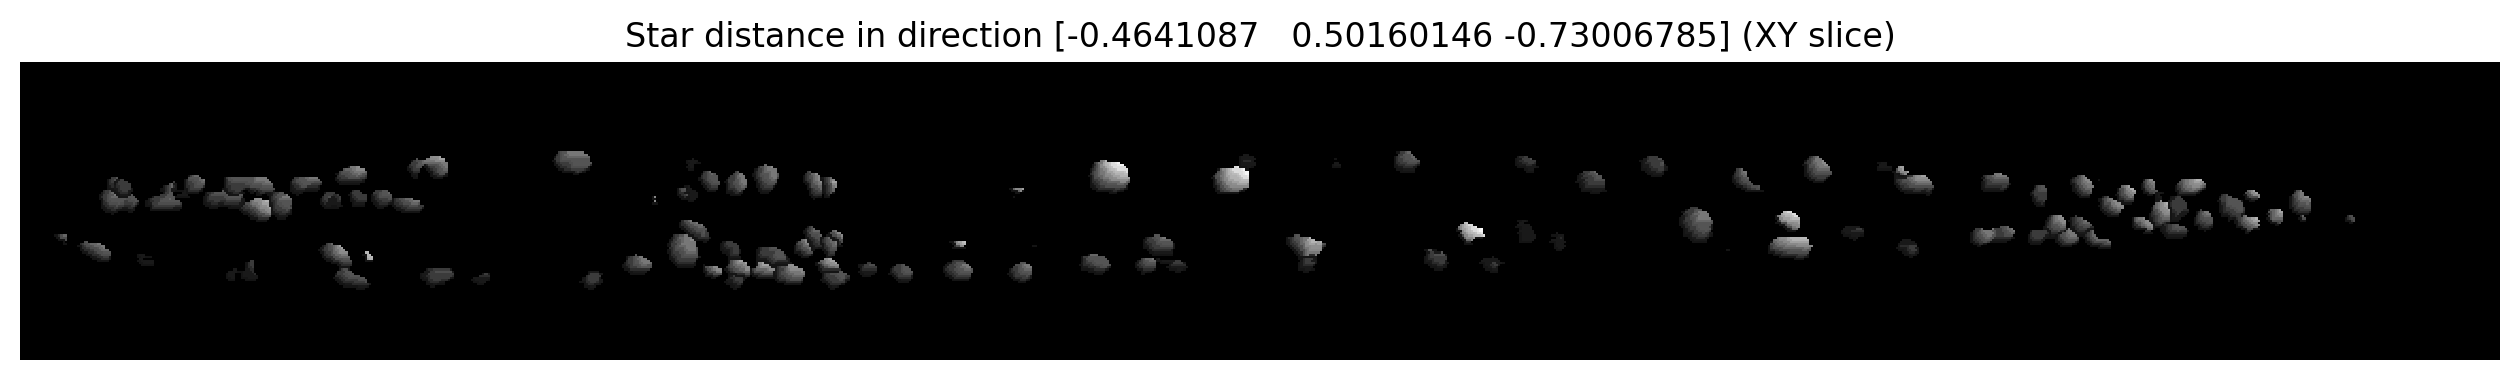

In [133]:
# Pick test instance
test_worm_id = 0
test_worm = ic.worms[test_worm_id]
test_mask = test_worm.mask

instance_id = test_worm.instance_ids[0]
test_instance = test_worm.instances[(test_worm_id, instance_id)]

# Create rays based on empirical anisotropy
anisotropy = calculate_anisotropy(test_mask) if USE_ANISOTROPY else None
print(f"Anisotropy of worm image: {anisotropy}")
rays = Rays_GoldenSpiral(NUM_RAYS, anisotropy=anisotropy)

# Compute stardist array
star_dist_array = star_dist3D(test_mask, rays)

# Compute ray distances from centroid
centroid = np.round(test_instance.centroid).astype(int)
print(f"Instance centroid: {test_instance.centroid}")
print(f"Centroid pixel: {centroid}")
dist = star_dist_array[centroid[0], centroid[1], centroid[2], :]
print(f"Ray distances from centroid: {dist}")

# Plot distance per pixel in some direction (2d slice)
ray_idx = 1
dist_img = star_dist_array[:,:,:,ray_idx]
z = dist_img.shape[0] // 2

plt.figure(figsize=(16,10))
plt.imshow(dist_img[z],cmap='gray')
plt.axis('off')
plt.title(f'Star distance in direction {rays.vertices[ray_idx]} (XY slice)');

In [138]:
print(test_instance.bounding_min)
print(test_instance.bounding_max)
diam = test_instance.bounding_max - test_instance.bounding_min
print(diam)

[ 80  64 401]
[ 89  77 414]
[ 9 13 13]


In [177]:
features = InstanceFeatures(ic)
features.extract_features(NUM_RAYS, USE_ANISOTROPY)
features.representations

Created instance representations (dim = 9) from:
- Relative centroids (dim = 3)
- Ray distances (dim = 6)


{(0,
  5): array([  14.20035073,   -2.49790703, -122.13661698,    6.        ,
           6.55743837,    7.14142847,    7.8740077 ,    6.78233004,
           4.        ]),
 (0,
  6): array([ -11.40221378,   -2.72481684, -136.93209475,    5.        ,
           6.55743837,    5.19615221,    7.14142847,    4.47213602,
           5.        ]),
 (0,
  26): array([ 10.5199629 , -21.61863544, -15.10592672,   6.        ,
          6.55743837,   7.14142847,   7.14142847,   5.47722578,
          6.        ]),
 (0,
  27): array([-13.37540577, -14.16164454,  64.13153376,   5.        ,
          4.89897966,   6.16441393,   7.14142847,   5.47722578,
          5.        ]),
 (0,
  28): array([  3.43298839, -10.9943696 , 477.61693522,   4.        ,
          6.55743837,   5.19615221,   7.14142847,   4.47213602,
          5.        ]),
 (0,
  29): array([ -7.5155369 , -13.86808011, 476.73035464,   5.        ,
          4.89897966,   6.16441393,   5.74456263,   4.47213602,
          5.        ]),
 (0,
 

(1026, 9)


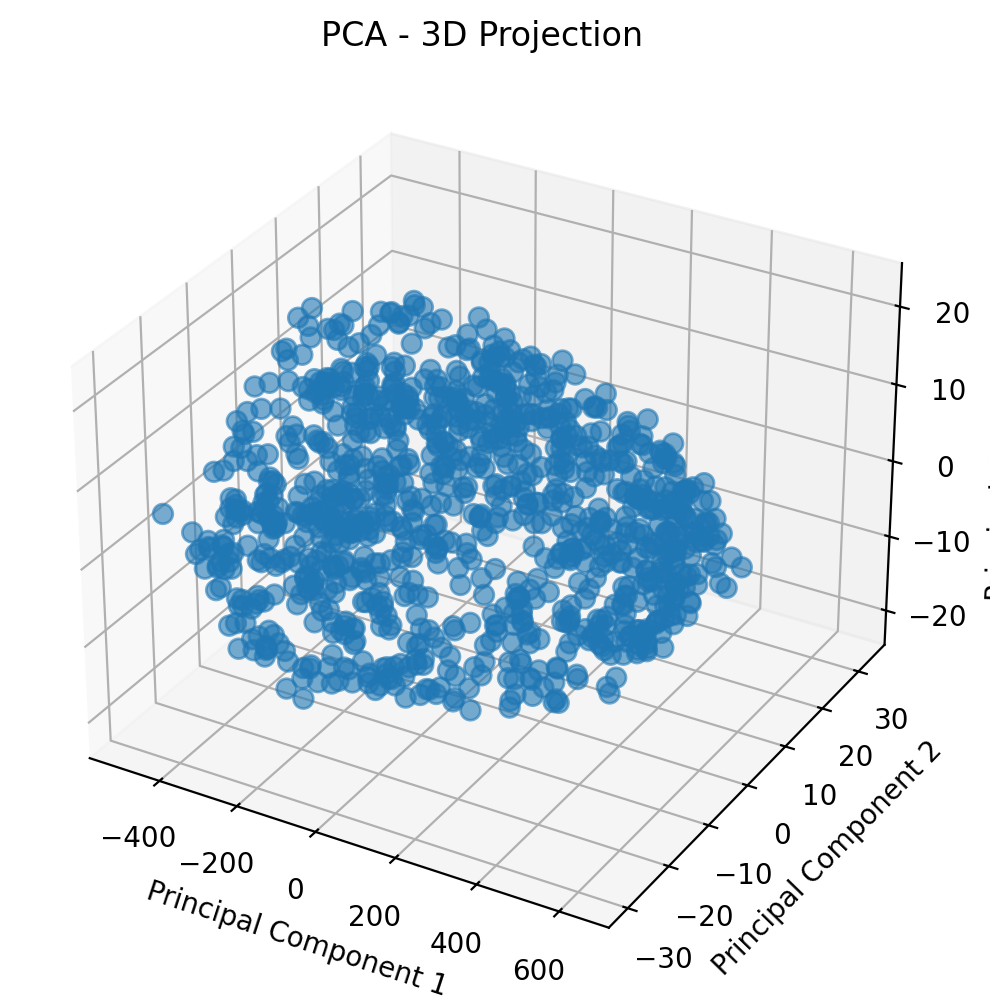

In [175]:
# Create a list of high-dimensional vectors (replace this with your data)
high_dimensional_data = np.array(list(features.representations.values())) 
print(high_dimensional_data.shape)

# Apply PCA to reduce dimensionality to 3 dimensions
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(high_dimensional_data)

# Plot the results in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], marker='o', s=50, alpha=0.6)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA - 3D Projection')

plt.show()

# 3. Nuclei Grouping

**Given:** To each pixel $p$ of each nucleus instance $P_{ij}$ we have assigned a high-dimensional feature vector $v_p$ consisting of all the computed/predicted features of that pixel, this vector reflects the geometry of the instance this pixel belongs to.

**Goal:** We want to find a transformation that moves alle feature vectors $v_p$ in such a way that a e can identify clusters. Ideally, pixels of the same instance are transformad to similar vectors. And, more important, pixels of different instances that represent "the same nucleus" in distinct worms are also transformad to similar vectors. This way, similar instances across all worms form dense vector clusters which represent the nuclei groups.

**Method:**
We create such a transfromation using metric learning. Two feature vectors are pushed together when:
- they belong to the same instance
- they belong to instances in distinct worms that have "similar geometry", i.e. have similar centroid and shape.

and are pulled apart when:
- they belong to distinct instances in the same worm
- they belong to instances in distinct worms that do not share the geomery features.
 
Then the transfromed feature vectors form a point cloud which can be clustered according to the densest regions using a suitable clustering algorithm based on density. Each dense cluster represents pixels of nuclei instances that are most similar across all worms. Ideally, there should be 558 clusters, but probably will be less depending on the number of segmented nuclei instances per worm.

In the last step the nuclei groups are formed as follows: Create one group per cluster which at first is empty. Then, for each instance across all worms find the cluster that contains the maximum of its pixels. Assign this instance to the corresponding group. Some finer details need to be figured out here, e.g. what happens is two instances of the same worm are assigned to the same group.

The final result is a list of groups containing one instance per worm that have similar geometry and are likely candidates for representing the same nucleus label.

<div class="alert alert-block alert-warning">
TODO:
This method can be tested independently of part (1) and the underlying segmentation model. Simply use either pre-segmented images or create a synthetic dataset and evaluate the Nuclei Grouping method there.
</div>


## 2.1. Create training data

In this section we create training data for learning the optimal transform $\Phi$ given a list of instance segmentation masks. We follow the ideas of StarDist here, using the predictions of the StarDist model to describe the instance shape.

More precisely, the training data consists of pairs $(x,y)$ where:
- $x=x_{ij}$ is a 4-dimensional WHDC-tensor corresponding to a patch containing instance $P_{ij}$. We use 4 channels here: one for the greyscale value of the pixel, and one for the xyz-pixel position each. This way we can encode the position and shape of an instance into a tensor without having to pass the whole worm image. This considerably reduces the training data size since the number of foreground pixels is small compared to image size.
- $y=y_{ij}$ is a 4-dimensional WHDC-tensor which contains a "geometry description vector" per pixel of the input patch in the channel dimension. More precisely, it contains a pixelwise prediction of 1) the probability that that pixel is the instance center (measured by the distance to background) and 2) the distances to a fixed set of directions. See StarDist for details on that approach.

## 2.2. Model training

Follow StarDist here.

After training we have the following function: For each pixel of an instance input patch we get
1) the center probability of the pixel (prediction using StarDist)
2) the distances w.r.t. to the fixed set of directions (prediction using StarDist)
3) the position of the pixel
4) the vector from the worm centroid to the instance centroid

## 2.4. Metric learning
Based on shape (2) and position (4) representations we use metric learning to transform the representaions using a metric loss:
- Pixels whose position vectors are almost equal are pushed together, pulled apart otherwise (equal in terms of angle and length)
- Pixels whose shape vectors are almost equal are pushed together, pulled apart otherwise (equal in terms of L2 loss (?))